### Data file
Download `ch_2Dxysec.pickle` from [Google Drive link here]  
Place it in the same folder as this notebook before running.
https://drive.google.com/file/d/19ghjbIuVy3_vPpnR69pDlErfsAQNSzcj/view?usp=sharing

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from scipy.interpolate import griddata
import pickle

# =============================
# LOAD DATA
# =============================
x_num = 256
y_num = 96

# Read coordinate data
xcor = pd.read_csv('./record_x.csv', header=None, delim_whitespace=True)
ycor = pd.read_csv('./record_y.csv', header=None, delim_whitespace=True)
xcor = xcor.values
ycor = ycor.values
xc = xcor[0:128, 0]
yc = ycor[0:48, 0]

datasetSerial = np.arange(20, 200020, 20)  # 10000 snapshots
print("Total snapshots:", len(datasetSerial))

gridSetting = (256, 96)
x_num = 128
y_num = 48

# Load pickle data
filename = "./ch_2Dxysec.pickle"
with open(filename, 'rb') as f:
    omg_flc_all = pickle.load(f)

dim_1 = 128
dim_2 = 48

sen_num_kind = 1
sen_num_var = 1
sen_num_kind_list = [50, 100, 200]
sen_num_var_list = [300, 100, 200, 1, 2]

width = dim_1
height = dim_2
x_ref, y_ref = np.meshgrid(yc, xc)

X_ki = np.zeros((10000 * sen_num_kind * sen_num_var, dim_1, dim_2, 2))
y_ki = np.zeros((10000 * sen_num_kind * sen_num_var, dim_1, dim_2, 1))

# =============================
# DATA GENERATION LOOP
# =============================
for ki in tqdm(range(sen_num_kind)):
    sen_num = sen_num_kind_list[ki]

    X_va = np.zeros((10000 * sen_num_var, dim_1, dim_2, 2))
    y_va = np.zeros((10000 * sen_num_var, dim_1, dim_2, 1))

    for va in range(sen_num_var):
        X_t = np.zeros((10000, dim_1, dim_2, 2))
        y_t = np.zeros((10000, dim_1, dim_2, 1))

        for t in tqdm(range(500), leave=False):
            y_t[t, :, :, 0] = omg_flc_all[t, :, :, 0]
            np.random.seed(sen_num_var_list[va])
            sparse_locations_lat = np.random.randint(dim_1, size=sen_num)
            sparse_locations_lon = np.random.randint(dim_2, size=sen_num)

            sparse_data = np.zeros(sen_num)
            for s in range(sen_num):
                sparse_data[s] = omg_flc_all[t, :, :, 0][
                    int(sparse_locations_lat[s]), int(sparse_locations_lon[s])
                ]

            sparse_locations_ex = np.zeros((sen_num, 2))
            for i in range(sen_num):
                sparse_locations_ex[i, 0] = xc[int(sparse_locations_lat[i])]
                sparse_locations_ex[i, 1] = yc[int(sparse_locations_lon[i])]

            grid_z0 = griddata(sparse_locations_ex, sparse_data, (y_ref, x_ref), method='nearest')
            X_t[t, :, :, 0] = grid_z0

            mask_img = np.zeros(grid_z0.shape)
            for i in range(sen_num):
                mask_img[int(sparse_locations_lat[i]), int(sparse_locations_lon[i])] = 1
            X_t[t, :, :, 1] = mask_img

        X_va[10000 * va:10000 * (va + 1), :, :, :] = X_t
        y_va[10000 * va:10000 * (va + 1), :, :, :] = y_t

    X_ki[(10000 * sen_num_var) * ki:(10000 * sen_num_var) * (ki + 1), :, :, :] = X_va
    y_ki[(10000 * sen_num_var) * ki:(10000 * sen_num_var) * (ki + 1), :, :, :] = y_va





/tmp/ipykernel_10096/1236017625.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xcor = pd.read_csv('./record_x.csv', header=None, delim_whitespace=True)
/tmp/ipykernel_10096/1236017625.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ycor = pd.read_csv('./record_y.csv', header=None, delim_whitespace=True)


Total snapshots: 10000


100%|██████████| 1/1 [00:09<00:00,  9.29s/it]


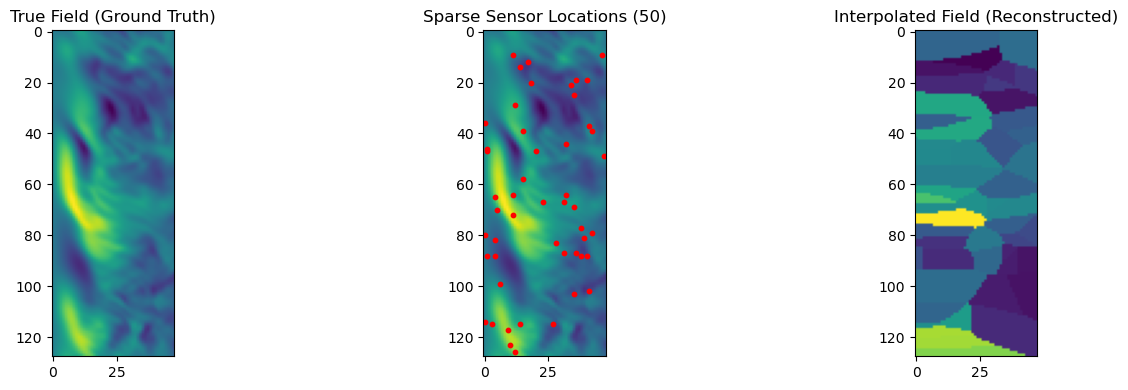

In [4]:
# Pick one time snapshot
t = 10  # any t < 500
sen_num = 50

# Random sensor positions
np.random.seed(0)
sparse_locations_lat = np.random.randint(dim_1, size=sen_num)
sparse_locations_lon = np.random.randint(dim_2, size=sen_num)

# True field
true_field = omg_flc_all[t, :, :, 0]

# Sparse sampled values
sparse_data = [true_field[sparse_locations_lat[i], sparse_locations_lon[i]] for i in range(sen_num)]
sparse_points = np.array([[xc[sparse_locations_lat[i]], yc[sparse_locations_lon[i]]] for i in range(sen_num)])

# Interpolated reconstruction
grid_z0 = griddata(sparse_points, sparse_data, (y_ref, x_ref), method='nearest')

# Visualization
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].imshow(true_field, cmap='viridis')
axs[0].set_title("True Field (Ground Truth)")

axs[1].imshow(true_field, cmap='viridis')
axs[1].scatter(sparse_locations_lon, sparse_locations_lat, color='red', s=10)
axs[1].set_title(f"Sparse Sensor Locations ({sen_num})")

axs[2].imshow(grid_z0, cmap='viridis')
axs[2].set_title("Interpolated Field (Reconstructed)")

plt.tight_layout()
plt.show()